In [1]:
%matplotlib inline

import copy
import numpy as np
import pylab as pl

from astropy import constants as const
import astropy.units as u
from astropy.cosmology import FlatwCDM
cosmo = FlatwCDM(H0=71, Om0=0.264, Ob0=0.044792699861138666, w0=-1.000000)

vc = const.c.to(u.km/u.second) # km/s
apr =  u.rad.to(u.arcsecond) # 1.0/np.pi*180.*3600        # 1/1^{''}

In [2]:
def make_r_coor(bs,nc):
    ds = bs/nc
    xx01 = np.linspace(-bs/2.0,bs/2.0-ds,nc)+0.5*ds
    xx02 = np.linspace(-bs/2.0,bs/2.0-ds,nc)+0.5*ds
    xg1,xg2 = np.meshgrid(xx01,xx02)
    return xg1,xg2

In [3]:
class StrongLensingSim(object):
    def __init__(self, xg1, xg2, lensCat, srcsCat, cosmology=cosmo):
        # meshgrids
        self.xg1 = xg1
        self.xg2 = xg2      
        # cosmological model
        self.cosmology = cosmology
        self.lensCat = copy.deepcopy(lensCat)
        self.srcsCat = copy.deepcopy(srcsCat)
        # lensing simulation
        self.create_lens_model()
        self.ray_shooting()
        self.generate_lensed_sersic()
        self.add_noise() # where you do modeling, you do not need to include this step
        
    def create_lens_model(self):
        # create mass model of lens and calculate deflection angles
        Das = self.cosmology.angular_diameter_distance(self.srcsCat['ZSRC']).value
        Dals= self.cosmology.angular_diameter_distance_z1z2(self.lensCat['ZLENS'], self.srcsCat['ZSRC']).value
        self.lensCat['REIN'] = 4.0*np.pi*(self.lensCat['VELDISP']/vc.value)**2.0*Dals/Das*apr        
        sx = self.xg1 - self.lensCat['XLENS']
        sy = self.xg2 - self.lensCat['YLENS']
        cs = np.cos(self.lensCat['PHIE'])
        sn = np.sin(self.lensCat['PHIE'])
        sx_r =  sx * cs + sy * sn
        sy_r = -sx * sn + sy * cs
        ql = 1.0-self.lensCat['ELLIP']
        fq = 1.0/(np.sqrt((1.+ql**2)/(2. * ql)))*np.sqrt((1 + ql**2)/2)
        reScale = self.lensCat['REIN']*fq
        rcScale = self.lensCat['RCORE']*np.sqrt((1 + ql**2) / (2*ql**2))
        psi = np.sqrt(ql**2.0*(rcScale**2.0+sx_r**2.0)+sy_r**2.0)
        if ql==1.0:
            dx_r = reScale*sx_r/(psi+rcScale)
            dy_r = reScale*sy_r/(psi+rcScale)
        else:
            dx_r = (reScale/np.sqrt((1.0-ql**2.0)))*np.arctan(np.sqrt((1.0-ql**2.0))*sx_r/(psi + rcScale))
            dy_r = (reScale/np.sqrt((1.0-ql**2.0)))*np.arctanh(np.sqrt((1.0-ql**2.0))*sy_r/(psi + rcScale*ql**2.0))
        # primary lens
        dx = dx_r * cs - dy_r * sn
        dy = dx_r * sn + dy_r * cs
        # external shear
        tr2 = self.lensCat['PHIG']
        cs2 = np.cos(2.0 * tr2)
        sn2 = np.sin(2.0 * tr2)
        dx2 = self.lensCat['GAMMA'] * (cs2 * sx + sn2 * sy)
        dy2 = self.lensCat['GAMMA'] * (sn2 * sx - cs2 * sy)
        # external kappa
        dx3 = self.lensCat['EXTKAPPA'] * sx
        dy3 = self.lensCat['EXTKAPPA'] * sy
        # total
        self.alpha1 = dx + dx2 + dx3
        self.alpha2 = dy + dy2 + dy3
        
    def ray_shooting(self):
        # shooting light rays from lens plane to source plane
        self.yg1 = self.xg1 - self.alpha1
        self.yg2 = self.xg2 - self.alpha2
        
    def generate_lensed_sersic(self):
        # generate lensed images of a source modeled by Sersic profile
        bn = 2.0*self.srcsCat['SINDEX']-1/3.0+0.009876/self.srcsCat['SINDEX']
        xi1new = (self.yg1-self.srcsCat['XSRC'])*np.cos(self.srcsCat['PHIS'])+(self.yg2-self.srcsCat['YSRC'])*np.sin(self.srcsCat['PHIS'])
        xi2new = (self.yg2-self.srcsCat['YSRC'])*np.cos(self.srcsCat['PHIS'])-(self.yg1-self.srcsCat['XSRC'])*np.sin(self.srcsCat['PHIS'])
        R_scale = np.sqrt((xi1new/self.srcsCat['ASRC'])**2+(xi2new/self.srcsCat['BSRC'])**2)
        R_scale_th = 0.01
        R_scale[R_scale<R_scale_th] = R_scale_th
        img = np.exp(-bn*((R_scale)**(1.0/self.srcsCat['SINDEX'])-1.0))
        self.lensed_images = img/np.exp(-bn*((R_scale_th)**(1.0/self.srcsCat['SINDEX'])-1.0))
        
    def add_noise(self):
        # add noise to the clean simulated images
        nx, ny = np.shape(self.lensed_images)
        mu, sigma = 0, np.max(self.lensed_images)*0.1
        noise_map = np.random.normal(mu, sigma, (nx, ny))
        self.lensed_images += noise_map
        
    def visualize_lensed_images(self):
        # visualize the output
        pl.figure(figsize=(8, 8))
        pl.imshow(self.lensed_images)

[[ 0.05967058 -0.06929984 -0.02811014 ...  0.02654474 -0.05024116
   0.07737676]
 [-0.2290063   0.03973831 -0.05855364 ...  0.04109389  0.0653887
  -0.15593691]
 [-0.01638159 -0.0217885  -0.0475297  ...  0.12231448  0.03851291
  -0.03411578]
 ...
 [ 0.07627882 -0.07877897 -0.06379918 ... -0.01613663 -0.05531172
   0.04831302]
 [ 0.00584689 -0.02917556  0.01196412 ... -0.060518   -0.09012943
  -0.1541149 ]
 [-0.06034495  0.03194026  0.01650395 ... -0.0825123   0.06494927
  -0.06991918]]


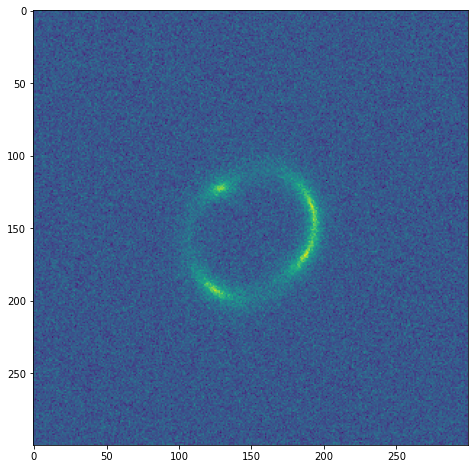

In [4]:
# lens parameters
lensCat_a = {}
lensCat_a['LENSID']  = 0
lensCat_a['VELDISP'] = 320.0 # velocity dispersion of the lens, km/s
lensCat_a['XLENS']   = 0.0   # angular position of the lens, arcsec
lensCat_a['YLENS']   = 0.0   # angular position of the lens, arcsec
lensCat_a['ZLENS']   = 0.5   # redshift of the lens
lensCat_a['ELLIP']   = 0.3   # ellipticity of the lens
lensCat_a['PHIE']    = 37/180*np.pi # position angule of the lens, rad
lensCat_a['RCORE']   = 0.0   # core size of the lens, arcsec
lensCat_a['GAMMA']   = 0.05  # external shear
lensCat_a['PHIG']    =-28/180*np.pi # position angle of the external shear, rad
lensCat_a['EXTKAPPA']= 0.0   # external convergence 

# source parameters
srcsCat_a = {}
srcsCat_a['ZSRC']    = 1.0   # redshift of the source
srcsCat_a['XSRC']    = 0.03  # angular position of the source, arcsec
srcsCat_a['YSRC']    = 0.15  # angular position of the source, arcsec
srcsCat_a['ASRC']    = 0.3   # major axis of the effective radius of the source, arcsec
srcsCat_a['BSRC']    = 0.2   # minor axis of the effective radius of the source, arcsec
srcsCat_a['PHIS']    = 77/180.*np.pi # position angle of the source, rad
srcsCat_a['SINDEX']  = 1.1 

# meshgrids
dsx = 0.03    # pixel size
nnn = 300     # number of pixels perside of the box
bsz = dsx*nnn # box size of the field of view
xi1, xi2 = make_r_coor(bsz, nnn)

test_a = StrongLensingSim(xi1, xi2, lensCat_a, srcsCat_a)

print(test_a.lensed_images)
test_a.visualize_lensed_images()